# Politico

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

from torch.utils.data import DataLoader, TensorDataset

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import os

In [12]:
# Load datasets
pwd = os.getcwd()

data = pd.read_csv(pwd + '\merged_data.csv')

# Convert date columns to datetime
data['date'] = pd.to_datetime(data['date'])

# Sort by date
data = data.sort_values('date')

# Reset index
data =data.reset_index(drop=True)

print("Politico Data Shape:", data.shape)


Politico Data Shape: (1350, 6)


## LSTM (without sentiment variables)

In [13]:
pwd = os.getcwd()

df = pd.read_csv(pwd + '\merged_data.csv')
df.head()

,date,Open,Close,Change,majority_sentiment,average_sentiment
0,2025-02-19,3820.56,3826.774,0.162777,0,0.711748
1,2025-02-14,3795.63,3787.966,-0.202022,1,0.518905
2,2025-02-03,3759.19,3779.815,0.548736,0,0.793771
3,2025-01-30,3729.03,3729.510,0.012899,0,0.856193
4,2025-01-29,3740.03,3729.029,-0.294142,0,0.783015


In [14]:
df.columns

Index(['date', 'Open', 'Close', 'Change', 'majority_sentiment',
       'average_sentiment'],
      dtype='object')

In [15]:

# Convert 'Date' column to datetime objects if it's not already
df['date'] = pd.to_datetime(df['date'])

# Select features and target variable
features = ['Open', 'Change'] # Add more relevant features
target = 'Close'

# Scale the features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features + [target]])

In [16]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length, -1]  # Target is the last column (Close price)
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


seq_length = 10 # Adjust the sequence length as needed
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]


# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # Output layer with one neuron for regression

model.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1) #Adjust epochs and batch size


# Evaluate the model on test data
loss = model.evaluate(X_test, y_test)


Epoch 1/50


34/34 [==============================] - 3s 7ms/step - loss: 0.0094
Epoch 2/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0015
Epoch 3/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0014
Epoch 4/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 5/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 6/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 7/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 8/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 9/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0010
Epoch 10/50
34/34 [==============================] - 0s 7ms/step - loss: 9.3841e-04
Epoch 11/50
34/34 [==============================] - 0s 7ms/step - loss: 9.1768e-04
Epoch 12/50
34/34 [==============================] - 0s 7ms/step - loss: 8.3726e-04
Epoch 13/50
34/34 [=============================

9/9 [==============================] - 1s 3ms/step
Test Loss (MSE): 0.00030056043760851026
Mean Absolute Error (MAE): 24.78531750110302
R-squared (R2): 0.9949907768421644


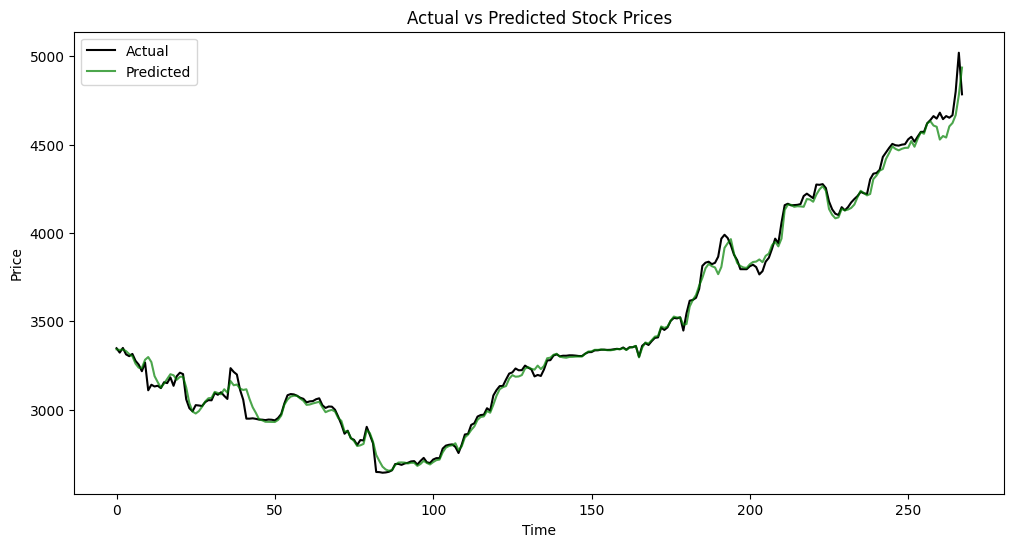

In [18]:
import matplotlib.pyplot as plt

# Predict on the test data
y_pred = model.predict(X_test)

# Inverse transform the scaled data to get actual prices
y_test_actual = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_actual = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_pred.reshape(-1, 1)), axis=1))[:, -1]

mae = mean_absolute_error(y_test_actual, y_pred_actual)

# Calculate R-squared (R2)
r2 = r2_score(y_test_actual, y_pred_actual)

# Print the results
print(f"Test Loss (MSE): {loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# Plot the actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual', color='black')
plt.plot(y_pred_actual, label='Predicted', color='green', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

## LSTM (with sentiment varaibles)

Epoch 1/50
34/34 [==============================] - 4s 7ms/step - loss: 0.0255
Epoch 2/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 3/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0014
Epoch 4/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 5/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 6/50
34/34 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 7/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 8/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 9/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 10/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 11/50
34/34 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 12/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0010
Epoch 13/50
34/34 [==============================

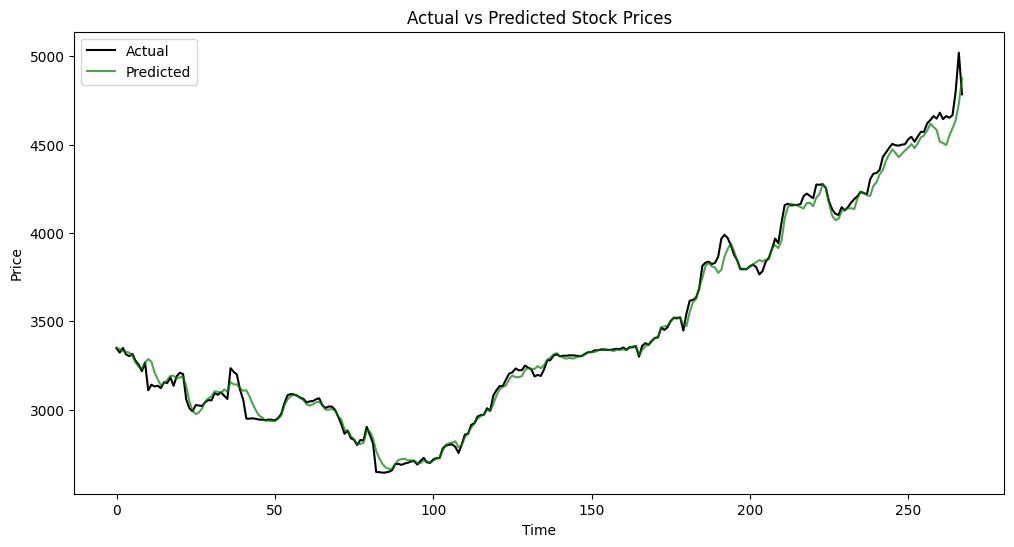

In [19]:
features = ['Open', 'Change', 'majority_sentiment', 'average_sentiment'] # Add more relevant features
target = 'Close'

# Scale the features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features + [target]])

# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length, -1]  # Target is the last column (Close price)
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


seq_length = 10 # Adjust the sequence length as needed
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]


# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # Output layer with one neuron for regression

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1) #Adjust epochs and batch size


# Evaluate the model on test data
loss = model.evaluate(X_test, y_test)


import matplotlib.pyplot as plt

# Predict on the test data
y_pred = model.predict(X_test)

# Inverse transform the scaled data to get actual prices
y_test_actual = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_actual = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_pred.reshape(-1, 1)), axis=1))[:, -1]

mae = mean_absolute_error(y_test_actual, y_pred_actual)

# Calculate R-squared (R2)
r2 = r2_score(y_test_actual, y_pred_actual)

# Print the results
print(f"Test Loss (MSE): {loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# Plot the actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual', color='black')
plt.plot(y_pred_actual, label='Predicted', color='green', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

## CNN (without sentiment)

In [20]:
df = pd.read_csv(pwd +'\merged_data.csv')
df.head()

,date,Open,Close,Change,majority_sentiment,average_sentiment
0,2025-02-19,3820.56,3826.774,0.162777,0,0.711748
1,2025-02-14,3795.63,3787.966,-0.202022,1,0.518905
2,2025-02-03,3759.19,3779.815,0.548736,0,0.793771
3,2025-01-30,3729.03,3729.510,0.012899,0,0.856193
4,2025-01-29,3740.03,3729.029,-0.294142,0,0.783015


In [21]:
# Assuming 'df' is your DataFrame
# Select relevant columns and convert the 'Date' column to datetime if it's not already
df['date'] = pd.to_datetime(df['date'])
data = df[['date', 'Close']]
data = data.set_index('date')

# Normalize the data
scaler = MinMaxScaler()
data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Prepare the data for the CNN
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10 # Example sequence length
X, y = create_sequences(data['Close'].values, seq_length)

# Reshape data for CNN input
X = X.reshape(X.shape[0], X.shape[1], 1)


# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(seq_length, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model 
model.fit(X, y, epochs=50, batch_size=32, verbose=1) # Adjust epochs and batch size as needed


Epoch 1/50
42/42 [==============================] - 1s 1ms/step - loss: 0.0461
Epoch 2/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 3/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 4/50
42/42 [==============================] - 0s 1ms/step - loss: 9.7459e-04
Epoch 5/50
42/42 [==============================] - 0s 1ms/step - loss: 9.2149e-04
Epoch 6/50
42/42 [==============================] - 0s 1ms/step - loss: 8.4634e-04
Epoch 7/50
42/42 [==============================] - 0s 1ms/step - loss: 8.2335e-04
Epoch 8/50
42/42 [==============================] - 0s 1ms/step - loss: 8.0437e-04
Epoch 9/50
42/42 [==============================] - 0s 1ms/step - loss: 7.3153e-04
Epoch 10/50
42/42 [==============================] - 0s 1ms/step - loss: 6.6222e-04
Epoch 11/50
42/42 [==============================] - 0s 1ms/step - loss: 6.4025e-04
Epoch 12/50
42/42 [==============================] - 0s 1ms/step - loss: 6.2608e-04
Epoch 13/50
4

42/42 [==============================] - 0s 1ms/step - loss: 3.5336e-04
Test Loss: 0.00035336255677975714
Mean Absolute Error (MAE): 25.180311178468074
R-squared (R2): 0.9922816297338651


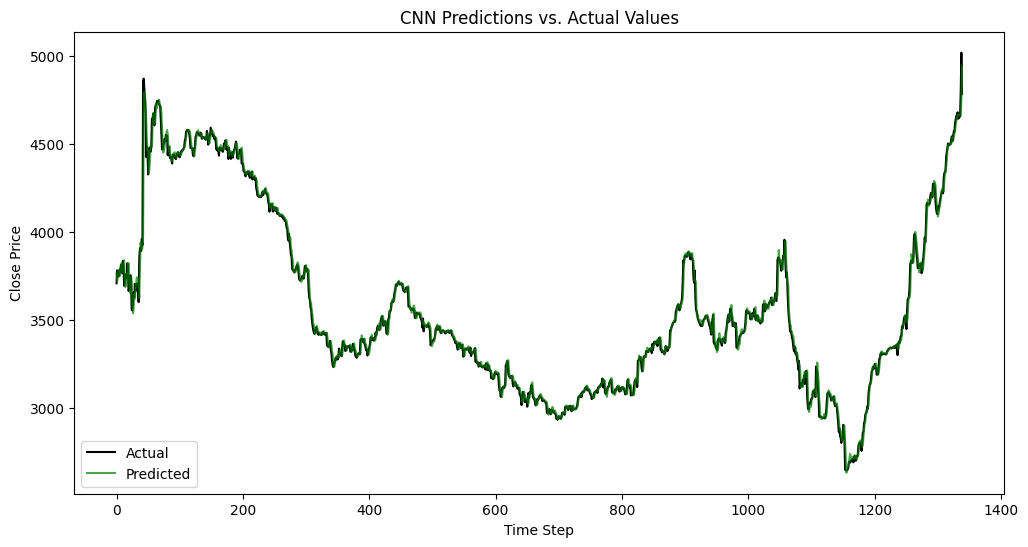

In [22]:
predictions = model.predict(X)

# Inverse transform the predictions and actual values to get original scale
predictions = scaler.inverse_transform(predictions)
y_original = scaler.inverse_transform(y.reshape(-1, 1))

# print loss
loss = model.evaluate(X, y)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_original, predictions)

# Calculate the R-squared (R2)
r2 = r2_score(y_original, predictions)

# Print the results
print(f"Test Loss: {loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")


# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(y_original, label='Actual', color='black')
plt.plot(predictions, label='Predicted', color='green', alpha=0.7)
plt.legend()
plt.title('CNN Predictions vs. Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.show()

In [23]:
dataset = pd.read_csv(pwd + '/merged_data.csv', index_col=0)
dataset.head()

,Open,Close,Change,majority_sentiment,average_sentiment
date,,,,,
2025-02-19,3820.56,3826.774,0.162777,0,0.711748
2025-02-14,3795.63,3787.966,-0.202022,1,0.518905
2025-02-03,3759.19,3779.815,0.548736,0,0.793771
2025-01-30,3729.03,3729.510,0.012899,0,0.856193
2025-01-29,3740.03,3729.029,-0.294142,0,0.783015


## CNN (with sentiment)

In [24]:
df = pd.read_csv(pwd +'\merged_data.csv')
df.head()

,date,Open,Close,Change,majority_sentiment,average_sentiment
0,2025-02-19,3820.56,3826.774,0.162777,0,0.711748
1,2025-02-14,3795.63,3787.966,-0.202022,1,0.518905
2,2025-02-03,3759.19,3779.815,0.548736,0,0.793771
3,2025-01-30,3729.03,3729.510,0.012899,0,0.856193
4,2025-01-29,3740.03,3729.029,-0.294142,0,0.783015


In [25]:
# Convert the 'date' column to datetime and set as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Select all features except 'Close' as input (X) and 'Close' as target (y)
feature_columns = df.columns[df.columns != 'Close']
target_column = 'Close'

# Normalize features and target separately
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

df[feature_columns] = scaler_X.fit_transform(df[feature_columns])
df[target_column] = scaler_y.fit_transform(df[[target_column]])

# Prepare the data for the CNN
def create_sequences(data_X, data_y, seq_length):
    xs, ys = [], []
    for i in range(len(data_X) - seq_length):
        xs.append(data_X[i:i+seq_length])
        ys.append(data_y[i+seq_length])
    return np.array(xs), np.array(ys)

seq_length = 10  # Example sequence length
X, y = create_sequences(df[feature_columns].values, df[target_column].values, seq_length)

# Reshape data for CNN input
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])  # (samples, time steps, features)

# Build the CNN model
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(seq_length, X.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, y, epochs=50, batch_size=32, verbose=1)  # Adjust epochs and batch size as needed

Epoch 1/50
42/42 [==============================] - 1s 2ms/step - loss: 0.0155
Epoch 2/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0029
Epoch 3/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 4/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 5/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 6/50
42/42 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 7/50
42/42 [==============================] - 0s 1ms/step - loss: 9.8701e-04
Epoch 8/50
42/42 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 9/50
42/42 [==============================] - 0s 1ms/step - loss: 8.8474e-04
Epoch 10/50
42/42 [==============================] - 0s 1ms/step - loss: 8.5283e-04
Epoch 11/50
42/42 [==============================] - 0s 1ms/step - loss: 9.4971e-04
Epoch 12/50
42/42 [==============================] - 0s 1ms/step - loss: 7.5373e-04
Epoch 13/50
42/42 [==========

42/42 [==============================] - 0s 1ms/step - loss: 5.7837e-04
Test Loss: 0.0005783701781183481
Mean Absolute Error (MAE): 45.980355162663265
R-squared (R2): 0.9874189197515572


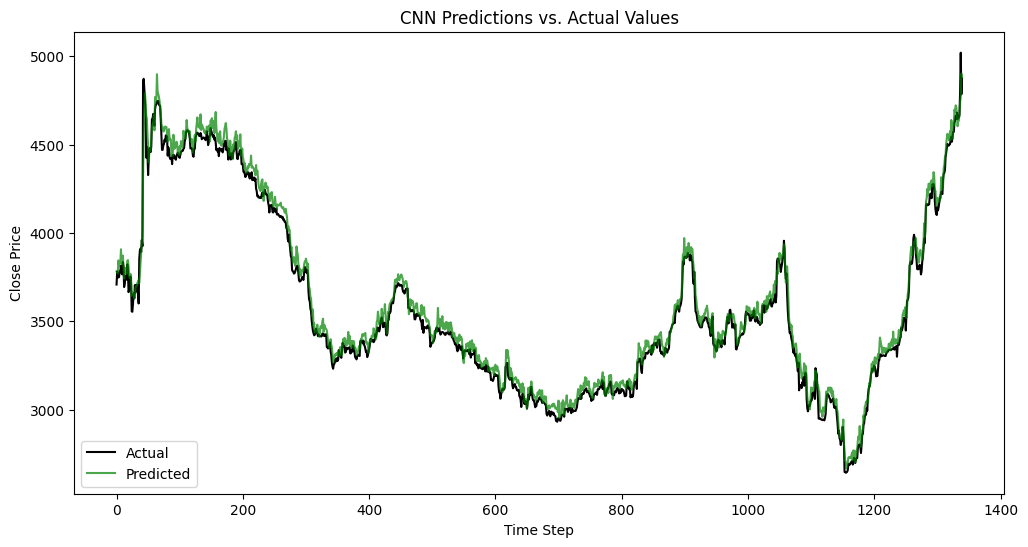

In [26]:
predictions = model.predict(X)

# Inverse transform the predictions and actual values to original scale
predictions = scaler_y.inverse_transform(predictions)
y_original = scaler_y.inverse_transform(y.reshape(-1, 1))

# Print loss
loss = model.evaluate(X, y)

# Calculate performance metrics
mae = mean_absolute_error(y_original, predictions)
r2 = r2_score(y_original, predictions)

# Print results
print(f"Test Loss: {loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(y_original, label='Actual', color='black')
plt.plot(predictions, label='Predicted', color='green', alpha=0.7)
plt.legend()
plt.title('CNN Predictions vs. Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.show()

## LSTM-CNN (with sentiment)

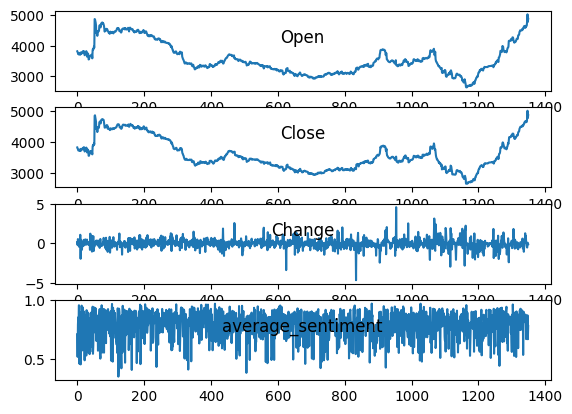

In [27]:
values = dataset.values

# specify columns to plot
groups = [0, 1, 2, 4]
i = 1

# plot each column
plt.figure()

for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='center')
    i += 1
plt.show()

In [28]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [29]:
# load dataset
dataset = pd.read_csv(pwd + '/merged_data.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
# encoder = LabelEncoder()
# values[:,3] = encoder.fit_transform(values[:,3])
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.columns)

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)'],
      dtype='object')


In [30]:
reframed.drop(reframed.columns[[5,7,8,9]], axis=1, inplace=True)  # drop all except var2(t) (Close price)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var2(t)
1   0.493933   0.497801   0.520982        0.0   0.580065  0.481476
2   0.483472   0.481476   0.481298        0.5   0.270463  0.478048
3   0.468182   0.478048   0.562967        0.0   0.711748  0.456887
4   0.455528   0.456887   0.504677        0.0   0.811964  0.456684
5   0.460143   0.456684   0.471277        0.0   0.694479  0.455045


In [31]:
values = reframed.values
n_train = int(len(values) * 0.8)
train = values[:n_train, :]
test = values[n_train:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1079, 1, 5) (1079,) (270, 1, 5) (270,)


In [32]:
n_samples = train_X.shape[0]
n_features = train_X.shape[2]

print(n_samples)
print(n_features)

1079
5


In [33]:
model = Sequential()

# 1D Convolutional Layer
model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(1, n_features)))

model.add(MaxPooling1D(pool_size=1))

# LSTM Layers
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

model.summary()

history = model.fit(train_X, train_y, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(test_X, test_y), 
                    verbose=2, 
                    shuffle=False)

# Predictions
yhat = model.predict(test_X)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 1, 64)             384       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 lstm_6 (LSTM)               (None, 1, 50)             23000     
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 43635 (170.45 KB)
Trainable params: 43635 (170.45 KB)
Non-trainable params: 0 (0.00 Byte)
________________

9/9 [==============================] - 0s 2ms/step - loss: 0.0028
Test Loss: 0.0027611758559942245
Mean Absolute Error: 0.040236763656139374
R-squared Score: 0.9546512365341187


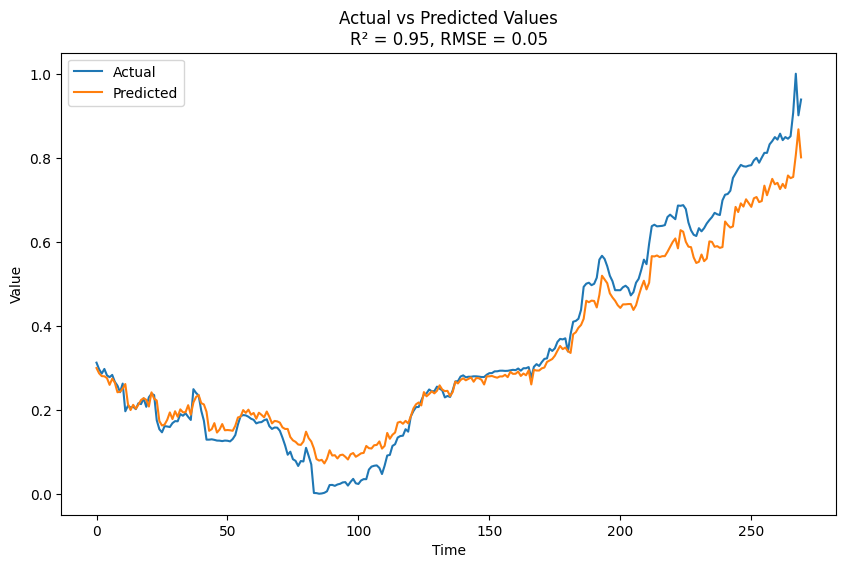

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(test_y, yhat)
mse = mean_squared_error(test_y, yhat)
rmse = np.sqrt(mse)
r2 = r2_score(test_y, yhat)
loss = model.evaluate(test_X, test_y)

print(f'Test Loss: {loss}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared Score: {r2}')

plt.figure(figsize=(10, 6))
plt.plot(test_y, label='Actual')
plt.plot(yhat, label='Predicted')
plt.title(f'Actual vs Predicted Values\nR² = {r2:.2f}, RMSE = {rmse:.2f}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

## LSTM-CNN (without sentiment)

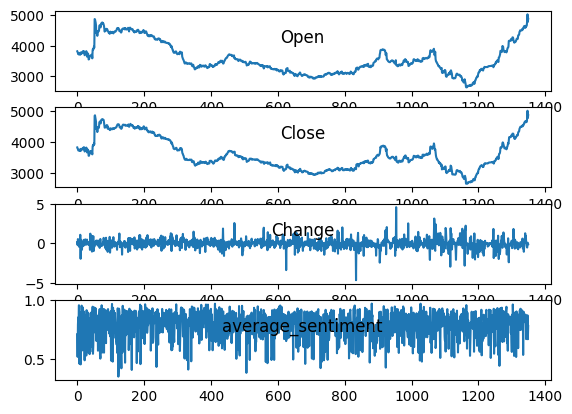

In [35]:
values = dataset.values

# specify columns to plot
groups = [0, 1, 2, 4]
i = 1

# plot each column
plt.figure()

for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='center')
    i += 1
plt.show()

In [36]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [37]:
# load dataset
dataset = pd.read_csv(pwd + '/merged_data.csv', header=0, index_col=0)
data = dataset[['Change', 'Close', 'Open']]
values = data.values
# integer encode direction
# encoder = LabelEncoder()
# values[:,3] = encoder.fit_transform(values[:,3])
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.columns)

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var1(t)', 'var2(t)', 'var3(t)'], dtype='object')


In [38]:
reframed.drop(reframed.columns[[3, 5]], axis=1, inplace=True)  # drop all except Close price
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var2(t)
1   0.520982   0.497801   0.493933  0.481476
2   0.481298   0.481476   0.483472  0.478048
3   0.562967   0.478048   0.468182  0.456887
4   0.504677   0.456887   0.455528  0.456684
5   0.471277   0.456684   0.460143  0.455045


In [39]:
values = reframed.values
n_train = int(len(values) * 0.8)
train = values[:n_train, :]
test = values[n_train:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1079, 1, 3) (1079,) (270, 1, 3) (270,)


In [40]:
n_samples = train_X.shape[0]
n_features = train_X.shape[2]

print(n_samples)
print(n_features)

1079
3


In [41]:
model = Sequential()

# 1D Convolutional Layer
model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(1, n_features)))

model.add(MaxPooling1D(pool_size=1))

# LSTM Layers
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

model.summary()

history = model.fit(train_X, train_y, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(test_X, test_y), 
                    verbose=2, 
                    shuffle=False)

# Predictions
yhat = model.predict(test_X)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 1, 64)             256       
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 lstm_8 (LSTM)               (None, 1, 50)             23000     
                                                                 
 lstm_9 (LSTM)               (None, 50)                20200     
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 43507 (169.95 KB)
Trainable params: 43507 (169.95 KB)
Non-trainable params: 0 (0.00 Byte)
________________

9/9 [==============================] - 0s 2ms/step - loss: 0.0021
Test Loss: 0.002081911079585552
Mean Absolute Error: 0.03492550179362297
R-squared Score: 0.965807318687439


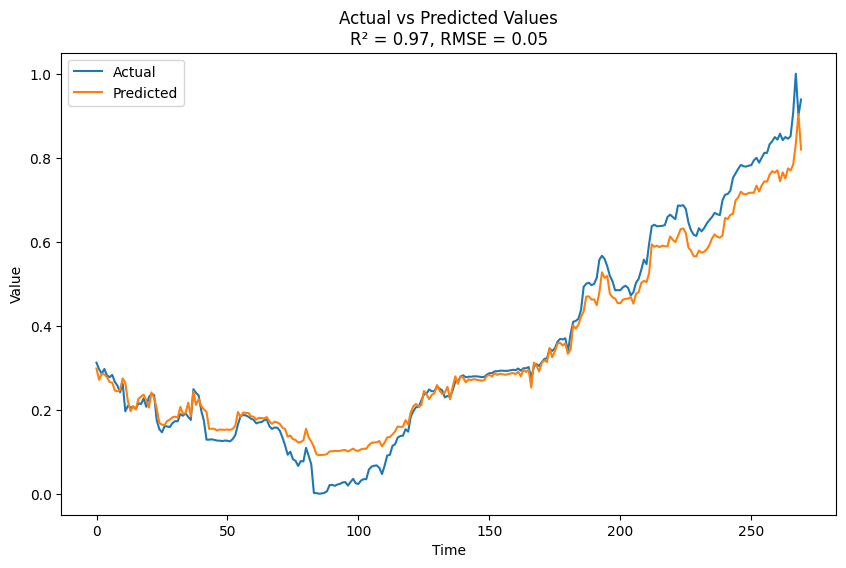

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(test_y, yhat)
mse = mean_squared_error(test_y, yhat)
rmse = np.sqrt(mse)
r2 = r2_score(test_y, yhat)
loss = model.evaluate(test_X, test_y)

print(f'Test Loss: {loss}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared Score: {r2}')

plt.figure(figsize=(10, 6))
plt.plot(test_y, label='Actual')
plt.plot(yhat, label='Predicted')
plt.title(f'Actual vs Predicted Values\nR² = {r2:.2f}, RMSE = {rmse:.2f}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

## rolling cross validation


---------------------------------------------------------------------------------------------------

## LSTM (without sentiment variables)

In [44]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length, -1]  # Target is the last column (Close price)
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Open', 'Close', 'Change']])

# Create sequences
seq_length = 10
X, y = create_sequences(scaled_data, seq_length)

# Define rolling cross validation parameters
n_splits = 5
train_size = int(len(X) * 0.8)  # Initial training size (70% of data)
test_size = int(len(X) * 0.2)   # Size of each test fold (10% of data)

# Store results for each fold
fold_results = []

# Perform rolling cross validation
for fold in range(n_splits):
    print(f'\nFold {fold + 1}')
    
    # Calculate rolling indices
    train_start = fold * test_size
    train_end = train_start + train_size
    test_start = train_end
    test_end = test_start + test_size
    
    # Ensure we don't exceed array bounds
    if test_end > len(X):
        break
        
    # Split data
    X_train = X[train_start:train_end]
    X_val = X[test_start:test_end]
    y_train = y[train_start:train_end]
    y_val = y[test_start:test_end]
    
    # Build and compile model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val),
        verbose=1
    )
    
    # Make predictions
    y_pred = model.predict(X_val)
    
    # Calculate metrics
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    fold_results.append({
        'fold': fold + 1,
        'mae': mae,
        'r2': r2
    })
    
    print(f'Fold {fold + 1} Results:')
    print(f'MAE: {mae:.4f}')
    print(f'R2 Score: {r2:.4f}')

# Print average results
avg_results = pd.DataFrame(fold_results).mean()
print('\nAverage Results:')
print(f'Average MAE: {avg_results["mae"]:.4f}')
print(f'Average R2 Score: {avg_results["r2"]:.4f}')


Fold 1
Epoch 1/50
34/34 [==============================] - 4s 29ms/step - loss: 0.0228 - val_loss: 0.0089
Epoch 2/50
34/34 [==============================] - 0s 9ms/step - loss: 0.0044 - val_loss: 0.0069
Epoch 3/50
34/34 [==============================] - 0s 8ms/step - loss: 0.0041 - val_loss: 0.0069
Epoch 4/50
34/34 [==============================] - 0s 8ms/step - loss: 0.0043 - val_loss: 0.0070
Epoch 5/50
34/34 [==============================] - 0s 8ms/step - loss: 0.0041 - val_loss: 0.0068
Epoch 6/50
34/34 [==============================] - 0s 9ms/step - loss: 0.0040 - val_loss: 0.0069
Epoch 7/50
34/34 [==============================] - 0s 8ms/step - loss: 0.0041 - val_loss: 0.0070
Epoch 8/50
34/34 [==============================] - 0s 8ms/step - loss: 0.0041 - val_loss: 0.0074
Epoch 9/50
34/34 [==============================] - 0s 8ms/step - loss: 0.0041 - val_loss: 0.0069
Epoch 10/50
34/34 [==============================] - 0s 9ms/step - loss: 0.0040 - val_loss: 0.0069
Epoch 11/5

## LSTM (with sentiment variables)

In [46]:
# Scale the data

data = pd.read_csv(pwd + '/merged_data.csv')
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Open', 'Close', 'Change', 'majority_sentiment', 'average_sentiment']])

# Create sequences
seq_length = 10
X, y = create_sequences(scaled_data, seq_length)

# Define rolling cross validation parameters
n_splits = 5
train_size = int(len(X) * 0.8)  # Initial training size (70% of data)
test_size = int(len(X) * 0.2)   # Size of each test fold (10% of data)

# Store results for each fold
fold_results = []

# Perform rolling cross validation
for fold in range(n_splits):
    print(f'\nFold {fold + 1}')
    
    # Calculate rolling indices
    train_start = fold * test_size
    train_end = train_start + train_size
    test_start = train_end
    test_end = test_start + test_size
    
    # Ensure we don't exceed array bounds
    if test_end > len(X):
        break
        
    # Split data
    X_train = X[train_start:train_end]
    X_val = X[test_start:test_end]
    y_train = y[train_start:train_end]
    y_val = y[test_start:test_end]
    
    # Build and compile model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val),
        verbose=1
    )
    
    # Make predictions
    y_pred = model.predict(X_val)
    
    # Calculate metrics
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    fold_results.append({
        'fold': fold + 1,
        'mae': mae,
        'r2': r2
    })
    
    print(f'Fold {fold + 1} Results:')
    print(f'MAE: {mae:.4f}')
    print(f'R2 Score: {r2:.4f}')

# Print average results
avg_results = pd.DataFrame(fold_results).mean()
print('\nAverage Results:')
print(f'Average MAE: {avg_results["mae"]:.4f}')
print(f'Average R2 Score: {avg_results["r2"]:.4f}')


Fold 1
Epoch 1/50
34/34 [==============================] - 4s 29ms/step - loss: 0.1112 - val_loss: 0.0325
Epoch 2/50
34/34 [==============================] - 0s 8ms/step - loss: 0.0377 - val_loss: 0.0319
Epoch 3/50
34/34 [==============================] - 0s 8ms/step - loss: 0.0368 - val_loss: 0.0317
Epoch 4/50
34/34 [==============================] - 0s 8ms/step - loss: 0.0380 - val_loss: 0.0316
Epoch 5/50
34/34 [==============================] - 0s 8ms/step - loss: 0.0366 - val_loss: 0.0321
Epoch 6/50
34/34 [==============================] - 0s 8ms/step - loss: 0.0365 - val_loss: 0.0330
Epoch 7/50
34/34 [==============================] - 0s 9ms/step - loss: 0.0369 - val_loss: 0.0344
Epoch 8/50
34/34 [==============================] - 0s 8ms/step - loss: 0.0367 - val_loss: 0.0318
Epoch 9/50
34/34 [==============================] - 0s 9ms/step - loss: 0.0371 - val_loss: 0.0319
Epoch 10/50
34/34 [==============================] - 0s 8ms/step - loss: 0.0371 - val_loss: 0.0314
Epoch 11/5

## CNN-LSTM (without sentiment variables)

In [47]:
# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Open', 'Close', 'Change']])

# Create sequences
seq_length = 10
X, y = create_sequences(scaled_data, seq_length)

# Initialize time series cross validation
tscv = TimeSeriesSplit(n_splits=5)

# Store results for each fold
fold_results = []

# Perform cross validation
for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    print(f'\nFold {fold + 1}')
    
    # Calculate train/test split points
    train_size = int(len(train_idx) * 0.8)
    train_start = 0
    train_end = train_size
    test_start = train_size
    test_end = len(train_idx)
    
    # Split data
    X_train = X[train_start:train_end]
    X_val = X[test_start:test_end]
    y_train = y[train_start:train_end]
    y_val = y[test_start:test_end]
    
    # Build and compile model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val),
        verbose=1
    )
    
    # Make predictions
    y_pred = model.predict(X_val)
    
    # Calculate metrics
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    fold_results.append({
        'fold': fold + 1,
        'mae': mae,
        'r2': r2
    })
    
    print(f'Fold {fold + 1} Results:')
    print(f'MAE: {mae:.4f}')
    print(f'R2 Score: {r2:.4f}')

# Print average results
avg_results = pd.DataFrame(fold_results).mean()
print('\nAverage Results:')
print(f'Average MAE: {avg_results["mae"]:.4f}')
print(f'Average R2 Score: {avg_results["r2"]:.4f}')


Fold 1
Epoch 1/50
6/6 [==============================] - 4s 154ms/step - loss: 0.1203 - val_loss: 0.0063
Epoch 2/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0214 - val_loss: 0.0213
Epoch 3/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0126 - val_loss: 0.0073
Epoch 4/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0131 - val_loss: 0.0040
Epoch 5/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0066 - val_loss: 0.0052
Epoch 6/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0070 - val_loss: 0.0021
Epoch 7/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0049 - val_loss: 0.0025
Epoch 8/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0048 - val_loss: 0.0020
Epoch 9/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0044 - val_loss: 0.0024
Epoch 10/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 11/50
6/6 [===

## CNN-LSTM (with sentiment variables)

In [48]:
# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Open', 'Close', 'Change', 'majority_sentiment', 'average_sentiment']])

# Create sequences
seq_length = 10
X, y = create_sequences(scaled_data, seq_length)

# Initialize time series cross validation
tscv = TimeSeriesSplit(n_splits=5)

# Store results for each fold
fold_results = []

# Perform cross validation
for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    print(f'\nFold {fold + 1}')
    
    # Calculate train/test split points
    train_size = int(len(train_idx) * 0.8)
    train_start = 0
    train_end = train_size
    test_start = train_size
    test_end = len(train_idx)
    
    # Split data
    X_train = X[train_start:train_end]
    X_val = X[test_start:test_end]
    y_train = y[train_start:train_end]
    y_val = y[test_start:test_end]
    
    # Build and compile model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val),
        verbose=1
    )
    
    # Make predictions
    y_pred = model.predict(X_val)
    
    # Calculate metrics
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    fold_results.append({
        'fold': fold + 1,
        'mae': mae,
        'r2': r2
    })
    
    print(f'Fold {fold + 1} Results:')
    print(f'MAE: {mae:.4f}')
    print(f'R2 Score: {r2:.4f}')

# Print average results
avg_results = pd.DataFrame(fold_results).mean()
print('\nAverage Results:')
print(f'Average MAE: {avg_results["mae"]:.4f}')
print(f'Average R2 Score: {avg_results["r2"]:.4f}')


Fold 1
Epoch 1/50
6/6 [==============================] - 4s 158ms/step - loss: 0.4024 - val_loss: 0.1506
Epoch 2/50
6/6 [==============================] - 0s 15ms/step - loss: 0.1061 - val_loss: 0.0886
Epoch 3/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0850 - val_loss: 0.0390
Epoch 4/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0627 - val_loss: 0.0501
Epoch 5/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0638 - val_loss: 0.0387
Epoch 6/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0587 - val_loss: 0.0431
Epoch 7/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0583 - val_loss: 0.0386
Epoch 8/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0578 - val_loss: 0.0391
Epoch 9/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0570 - val_loss: 0.0384
Epoch 10/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0567 - val_loss: 0.0385
Epoch 11/50
6/6 [===

# CNN (BOTH)



In [49]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, -1])  # Assuming the target variable is the last column
    return np.array(X), np.array(y)

# Load your dataset (replace with actual data)
data = pd.read_csv(pwd + '\merged_data.csv')

# Convert date column to datetime
data['date'] = pd.to_datetime(data['date'])

# Sort by date
data = data.sort_values('date')

# Reset index
data = data.reset_index(drop=True)

print("Dataset Shape:", data.shape)

# Define a function to train and evaluate the CNN model
def train_cnn(data, features, title):
    print(f"\n### {title} ###")
    
    # Scale the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data[features])
    
    # Create sequences
    seq_length = 10
    X, y = create_sequences(scaled_data, seq_length)
    
    # Calculate number of samples for 20% test size
    test_size = 0.2
    window_size = int(len(X) * (1 - test_size))
    step_size = int(window_size * 0.2)  # Move window by 20% each time
    
    fold_results = []
    fold = 1
    
    # Perform rolling cross-validation
    for start_idx in range(0, len(X) - window_size, step_size):
        print(f'\nFold {fold}')
        
        # Define training and validation indices
        train_idx = list(range(start_idx, start_idx + window_size))
        val_idx = list(range(start_idx + window_size, min(start_idx + window_size + int(window_size * test_size/(1-test_size)), len(X))))
        
        # Split data
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Build and compile model
        model = Sequential([
            Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
            MaxPooling1D(pool_size=2),
            Conv1D(filters=32, kernel_size=3, activation='relu'),
            MaxPooling1D(pool_size=2),
            Flatten(),
            Dense(50, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        
        # Train model
        history = model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=32,
            validation_data=(X_val, y_val),
            verbose=1
        )
        
        # Make predictions
        y_pred = model.predict(X_val)
        
        # Calculate metrics
        mae = mean_absolute_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        
        fold_results.append({'fold': fold, 'mae': mae, 'r2': r2})
        
        print(f'Fold {fold} Results:')
        print(f'MAE: {mae:.4f}')
        print(f'R2 Score: {r2:.4f}')
        
        fold += 1
    
    # Print average results
    avg_results = pd.DataFrame(fold_results).mean()
    print('\nAverage Results:')
    print(f'Average MAE: {avg_results["mae"]:.4f}')
    print(f'Average R2 Score: {avg_results["r2"]:.4f}')

# Train CNN models
train_cnn(data, ['Open', 'Close', 'Change'], "CNN (Without Sentiment)")
train_cnn(data, ['Open', 'Close', 'Change', 'majority_sentiment', 'average_sentiment'], "CNN (With Sentiment)")
        
        # Make predictions
y_pred = model.predict(X_val)

# Calculate metrics
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

fold_results.append({'fold': fold, 'mae': mae, 'r2': r2})

print(f'Fold {fold} Results:')
print(f'MAE: {mae:.4f}')
print(f'R2 Score: {r2:.4f}')

fold += 1

# Print average results
avg_results = pd.DataFrame(fold_results).mean()
print('\nAverage Results:')
print(f'Average MAE: {avg_results["mae"]:.4f}')
print(f'Average R2 Score: {avg_results["r2"]:.4f}')

# Train CNN models for Malta Independent (MI)
train_cnn(data, ['Open', 'Close', 'Change'], "CNN (MI - Without Sentiment)")
train_cnn(data, ['Open', 'Close', 'Change', 'majority_sentiment', 'average_sentiment'], "CNN (MI - With Sentiment)")


Dataset Shape: (1350, 6)

### CNN (Without Sentiment) ###

Fold 1
Epoch 1/50
34/34 [==============================] - 1s 6ms/step - loss: 0.0456 - val_loss: 0.0063
Epoch 2/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0070 - val_loss: 0.0032
Epoch 3/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0026
Epoch 4/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0055 - val_loss: 0.0027
Epoch 5/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0026
Epoch 6/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0026
Epoch 7/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0033
Epoch 8/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0031
Epoch 9/50
34/34 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0033
Epoch 10/50
34/34 [==============================] -

# Results

# Results of models (using 80:20 split)
### LSTM (Without Sentiment Variable)
Test Loss (MSE): 0.00030056043760851026  
Mean Absolute Error (MAE): 24.78531750110302  
R-squared (R2): 0.9949907768421644  

### LSTM (With Sentiment Variable)
Test Loss (MSE): 0.000396626943256706  
Mean Absolute Error (MAE): 28.85114236110907  
R-squared (R2): 0.9933897051486382  

### CNN (Without Sentiment Variable)
Test Loss: 0.00035336255677975714  
Mean Absolute Error (MAE): 25.180311178468074  
R-squared (R2): 0.9922816297338651  

### CNN (With Sentiment Variable)
Test Loss: 0.0005783701781183481  
Mean Absolute Error (MAE): 45.980355162663265  
R-squared (R2): 0.9874189197515572  

### LSTM-CNN (Without Sentiment Variable)
Test Loss: 0.002081911079585552  
Mean Absolute Error: 0.03492550179362297  
R-squared Score: 0.965807318687439  

### LSTM-CNN (With Sentiment Variable)
Test Loss: 0.0027611758559942245  
Mean Absolute Error: 0.040236763656139374  
R-squared Score: 0.9546512365341187  

# Results of models (using time series rolling cross validation)
### LSTM (Without Sentiment)
Average Results:  
Average MAE: 0.0567  
Average R2 Score: 0.0101   

### LSTM (With Sentiment)
Average Results:  
Average MAE: 0.1483  
Average R2 Score: -0.0175  

### CNN (Without Sentiment)
Average Results:  
Average MAE: 0.0405  
Average R2 Score: -0.1345  

### CNN (With Sentiment)
Average Results:  
Average MAE: 0.2021  
Average R2 Score: -0.1669  

### CNN-LSTM (Without Sentiment)
Average Results:  
Average MAE: 0.0479  
Average R2 Score: -0.1267   

### CNN-LSTM (WitH Sentiment)
Average Results:
Average MAE: 0.1475
Average R2 Score: -0.0331

Here’s the updated analysis incorporating the new results with the same structure as before:

---

Based on your model results from the two news sources (Malta Independent and Malta Business Weekly), I'll analyze the impact of different sentiment sources and the value added by including sentiment variables.

## Q1: Impact of Different Sources for Sentiment

When comparing the Malta Independent vs. Malta Business Weekly as sentiment sources:

### **LSTM Models**
- **With Sentiment**: Malta Independent performs better in an 80:20 split (R² 0.949 vs. 0.867), but worse in time-series CV (-0.121 vs. -0.037).  
- **Without Sentiment**: Malta Independent performs better in an 80:20 split (R² 0.850 vs. 0.836) but worse in time-series CV (-0.352 vs. -0.031).

### **CNN Models**
- **With Sentiment**: Malta Independent performs better in an 80:20 split (R² 0.996 vs. 0.938), but worse in time-series CV (-0.246 vs. -0.098).  
- **Without Sentiment**: Malta Independent performs better in an 80:20 split (R² 0.993 vs. 0.892), but worse in time-series CV (-0.327 vs. -0.188).

### **LSTM-CNN Models**
- **With Sentiment**: Malta Business Weekly performs better in an 80:20 split (R² 0.926 vs. 0.877) and in time-series CV (-0.096 vs. -0.101).  
- **Without Sentiment**: Malta Independent performs better in an 80:20 split (R² 0.981 vs. 0.919), but Malta Business Weekly performs better in time-series CV (-0.056 vs. -0.297).

### **Key Findings:**
1. **In the 80:20 split**, Malta Independent generally provides stronger sentiment signals, especially for simpler models like LSTM and CNN.  
2. **In time-series cross-validation**, Malta Business Weekly consistently performs better, suggesting its sentiment scores might be more stable over time.  
3. **LSTM-CNN models** favor Malta Business Weekly sentiment data, potentially due to its structure capturing temporal patterns better.  

---

## Q2: Added Value of Sentiment Variable

### **Malta Independent**
#### **80:20 Split**
- **LSTM**: Adding sentiment improves R² from 0.850 to 0.949 (+11.7%).  
- **CNN**: Adding sentiment improves R² from 0.993 to 0.996 (+0.3%).  
- **LSTM-CNN**: Adding sentiment **decreases** R² from 0.981 to 0.877 (-10.6%).  

#### **Time-Series Cross Validation**
- **LSTM**: Adding sentiment improves R² from -0.352 to -0.121 (+23.1%).  
- **CNN**: Adding sentiment **decreases** R² from -0.327 to -0.246 (-8.1%).  
- **LSTM-CNN**: Adding sentiment **improves** R² from -0.297 to -0.101 (+19.6%).  

### **Malta Business Weekly**
#### **80:20 Split**
- **LSTM**: Adding sentiment improves R² from 0.836 to 0.867 (+3.7%).  
- **CNN**: Adding sentiment improves R² from 0.892 to 0.938 (+5.1%).  
- **LSTM-CNN**: Adding sentiment improves R² from 0.919 to 0.926 (+0.8%).  

#### **Time-Series Cross Validation**
- **LSTM**: Adding sentiment **decreases** R² from -0.031 to -0.037 (-0.6%).  
- **CNN**: Adding sentiment **improves** R² from -0.188 to -0.098 (+9.0%).  
- **LSTM-CNN**: Adding sentiment **decreases** R² from -0.056 to -0.096 (-4.0%).  

### **Key Findings:**
1. **In an 80:20 split**, sentiment generally improves performance, especially for LSTM models using Malta Independent sentiment.  
2. **In time-series cross-validation**, sentiment's impact is less clear—sometimes improving results, sometimes reducing stability.  
3. **For Malta Independent**, sentiment helps LSTM models but degrades CNN and hybrid LSTM-CNN performance.  
4. **For Malta Business Weekly**, sentiment has a more balanced impact across models, but the improvements are smaller.  

### **Conclusion:**
Sentiment data does add predictive value, particularly when using a static 80:20 split. However, its effectiveness diminishes when using time-series cross-validation, suggesting possible **overfitting in holdout testing** or that sentiment is **not consistently predictive over time**. Malta Independent sentiment is stronger in short-term predictions, while Malta Business Weekly sentiment appears more stable for time-series validation.